# Homework 4: Apply k-NN and Linear Regression
DATA 202 FA19 @ Calvin University

**Due**: Thursday October 10 @ 11:59pm

## Purpose

In this homework, you will apply what you learned in Homework 3 in a different situation. You'll also use the same tools to fit a linear regression, and compare and contrast the two modeling approaches.

After completing this assignment, you should be more comfortable with:

* The concepts of training and testing data
* The similarities and differences between Nearest-Neighbors regression and Linear Regression
* The sklearn regression API
* Working with Pandas DataFrames.

## Tasks

The instructions below will guide you through completing this assignment. A few strategic recommendations:

* Read through the whole thing before starting to get an overview
* Identify something that's unclear, or some knowledge you might be missing, and ask a question on Piazza.
* As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach.
* **Avoid** getting stuck on one part for a long time. Take breaks.
* Try not to Google anything or copy code off the Internet. You should be able to do this referring only to:
  - your hw3 "notes" (and maybe your solutions)
  - the Pandas documentation (remember the shift-tab-tab trick in Jupyter Notebook, and the links in the Help menu
  - the Data 100 textbook
* Check your understanding as you go. Master this.


Before you begin, please fill out [THIS GOOGLE FORM](https://docs.google.com/forms/d/e/1FAIpQLSdS1pi1AkbnnvXTwiVyz-BoB3yWtmysATlMVKDZcZEjV1RJJg/viewform?usp=sf_link).

## Criteria for Success

A successful submission will have these characteristics:

* All questions are answered
* All code is correct and succinct. (There should be no extraneous code.)
* Short answers should be *correct* (answering all parts), *clear* (easy to understand), and *concise*. Bullet points are fine if each point is a complete thought. (Use no more than 3 or 4 lines of text.)
* Where possible, free response answers should connect the *data* with the *real world*.
* Plots should be well documented: we will expect appropriate titles, axis labels, legends, etc. **The following question serves as a good guideline on what is "enough": If I directly downloaded the plot and viewed it, would I be able to tell what was being visualized without knowing the question?**

### How to Submit

Fill in the following information within this cell:

* **I worked with**:
* **One question I asked (either of another person, on Piazza, or of the Internet) was**:
* **This assignment actually took me**: 
* **The hardest part was**: 

Then:

* Rename this file to `hw4_username.ipynb`, replacing `username` with your Calvin username
* Run `Kernel->Restart and Run All` and check that everything works.
* Submit your `ipynb` file (only) to Moodle.


# Question 1: Setup

You started working with the Capital Bike Share dataset in Homework 2. We're going to extend our work there to try to predict ridership.

Our basic goal will be to try to predict ridership in 2012 based on ridership data in 2011. So the 2011 data will be our *training set* and the 2012 data will be our *test set* (aka *held-out* data or sometimes *validation* data).

First, we'll load up the data.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

# Set some display settings.
sns.set(context='notebook')

In [2]:
hourly_counts_orig = pd.read_csv('data/hour.csv')
hourly_counts_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


## Question 1.1: Renaming
Some of those column names are pretty awful. It's as if the authors didn't know that they could (usually) tab-complete column names! Let's fix a few of them up. Use the `rename` method on the `hourly_counts_orig` DataFrame to rename the following columns:

old | new
---|----
dteday | date
hr | hour
mnth | month
cnt | riders

Store the result in a variable called `hourly_counts` (keeping `_orig` untouched).

In [3]:
# your code here
hourly_counts = hourly_counts_orig.rename(columns={
    'dteday': 'date',
    'hr': "hour",
    'mnth': "month",
    'weekday': "day_of_week",
    'holiday': "is_holiday",
    'workingday': "is_workingday",
    'weathersit': "weather_type",
    "hum": "humidity",
    'cnt': "riders"
}).drop(["instant", "casual", "registered"], axis=1)
hourly_counts['day_of_year'] = pd.to_datetime(hourly_counts['date']).dt.dayofyear
cols = list(hourly_counts.columns)
cols.insert(1, cols.pop(cols.index("day_of_year")))
cols.insert(4, cols.pop(cols.index("day_of_week")))
cols.insert(4, cols.pop(cols.index("day_of_week")))
hourly_counts = hourly_counts[cols]

In [4]:
assert hourly_counts['hour'].max() == 23
assert hourly_counts['riders'].max() > 900

## Question 1.2: Train-Test Split
We're going to use 2011 as the training set and 2012 as the test set. **Make two new DataFrames based on `hourly_counts`, one called `train` containing only data from 2011, and one called `test` containing only 2012 data.**

The dataset already has a column, `yr`, which tells the two apart. I won't tell you what the values in the `yr` column mean; you can figure them out.

In [5]:
hourly_counts.yr.value_counts()

1    8734
0    8645
Name: yr, dtype: int64

In [6]:
# your code here
train = hourly_counts[hourly_counts.yr == 0]
test = hourly_counts[hourly_counts.yr == 1]

In [7]:
assert train['date'].iloc[0] == '2011-01-01'
assert test['date'].iloc[0] == '2012-01-01'
assert all(train['date'].str.startswith('2011'))
assert all(test['date'].str.startswith('2012'))
assert len(train) + len(test) == len(hourly_counts)

In [8]:
train.drop(["yr"], axis=1).head()

,date,day_of_year,season,day_of_week,month,hour,is_holiday,is_workingday,weather_type,temp,atemp,humidity,windspeed,riders
0,2011-01-01,1,1,6,1,0,0,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01,1,1,6,1,1,0,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01,1,1,6,1,2,0,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01,1,1,6,1,3,0,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01,1,1,6,1,4,0,0,1,0.24,0.2879,0.75,0.0,1


## Question 1.3: Sizes
1. How many observations are in the training set and the test set?
2. How many observations should there be? How many are missing?
3. Can you come up with a guess of why some observations might be missing? (there are masy possible answers here)


In [9]:
# your code here
print(f"{len(train)} observations in training set, {len(test)} in test set")
print(f"There were {365 * 24} hours in 2011, so {365 * 24 - len(train)} training-set observations are missing")
print(f"There were {366 * 24} hours in 2012, so {366 * 24 - len(test)} test-set observations are missing.")
print("Min ridership in training set:", min(train['riders']), "test set:", test['riders'].min())

8645 observations in training set, 8734 in test set
There were 8760 hours in 2011, so 115 training-set observations are missing
There were 8784 hours in 2012, so 50 test-set observations are missing.
Min ridership in training set: 1 test set: 1


*your answer here*
1. There are 8645 observations in the training set and 8734 in the test set.
2. There should be $365*24=8760$ in 2011 and $366*24=8784$ in 2012 (because 2012 was a leap year). So 115 hours are missing from the training set and 50 are missing from the test set.
3. My guess is that hours with no riders were missing, since the minimum in both sets is 1 rider. But there could also have been problems with data logging, mistakes in joining the bike data with the weather data, etc.

# Question 2: Predicting Ridership using a Single Predictor

What would be some simple predictors of ridership? One that comes to mind is temperature: sometimes it's just too cold to bike. Let's try using temperature to predict ridership.

## Question 2.1
The following code makes a scatterplot that attempts to show how ridership depends on temperature.

1. What is one observation you can make about this relationship based on this graph? Use "real world" language as much as you can.
2. What's one thing that's unclear about this graph? (What makes the relationship hard to see?) What's one thing you might change to improve it? (You don't have to actually make that change.)

*Note*: Temperature was "normalized" (we'll discuss more about this shortly). Here's how the dataset page says they computed it:

```
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
```


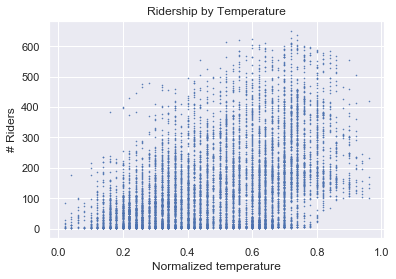

In [10]:
plt.scatter(train['temp'], train['riders'], s=.3)
plt.xlabel("Normalized temperature")
plt.ylabel("# Riders")
plt.title("Ridership by Temperature");

*Your answer here*

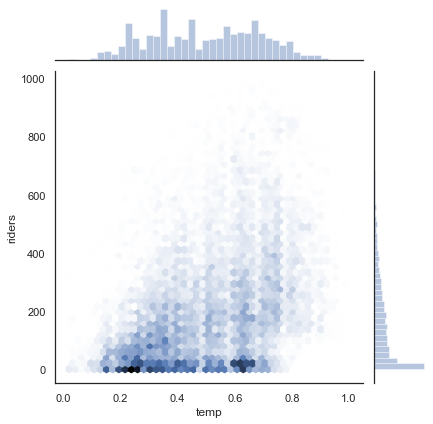

In [11]:
# Your alternate code here
# Here is one potential alternative plot.
with sns.axes_style('white'):
    sns.jointplot(x='temp', y='riders', kind='hex', data=hourly_counts)#, scatter_kws=dict(alpha=.2))

## Question 2.2
Fit a Nearest-Neighbors model to the training data, using the same predictor (`temp`) and response (`riders`). Plot the model's predictions on top of a scatterplot of the data.

*Note* This should be extremely familiar from hw3. If you need to copy-paste the new-axis stuff that's fine, but try to do the k-NN and plotting from just your notes.

*Hint*: Try `train[['temp']].values`.

### Step 1: Extract the training data
Make variables `train_x` and `train_y` containing the data for this prediction problem.

In [12]:
# Your code here
train_x = train[['temp']].values
train_y = train['riders'].values

In [13]:
assert train_x.ndim == 2
assert train_x.shape[1] == 1
assert train_y.ndim == 1
assert len(train_x) == len(train_y)

### Step 2: Train the k-NN model on the training data
Call it `knn`. Use 5 neighbors.

In [14]:
# Your code here
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(train[['temp']], train['riders'])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [15]:
assert knn.n_neighbors == 5

### Step 3: Evaluate what the model predicts for each temperature.

Make variables called `x` and `y_predicted`

In [16]:
# Your code here
x = np.linspace(0, 1, 100).reshape(-1, 1)
y_predicted = knn.predict(x)

### Step 4: Make the plot.
Remember to label it. Try to make both the predictions and the raw data show up clearly.

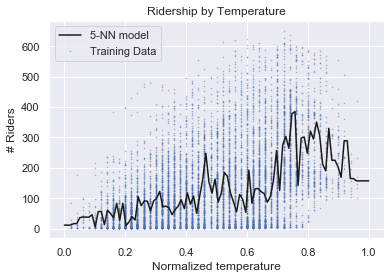

In [17]:
# your code here
plt.scatter(train['temp'], train['riders'], s=.3, alpha=.5, label="Training Data")
plt.plot(x, y_predicted, color='k', label="5-NN model")
plt.xlabel("Normalized temperature")
plt.ylabel("# Riders")
plt.title("Ridership by Temperature")
plt.legend();

## Question 2.3
What mean squared error does the 5-NN model get when predicting on the training data?

### Step 1: Make a prediction for each training-set observation.
Call it `train_y_predicted`.


In [18]:
# Your code here (one line)
train_y_predicted = knn.predict(train_x)

### Step 2: Write a function to compute the mean squared error.

In [19]:
def mean_squared_error(y_true, y_predicted):
    """Compute the MSE of a model that predicts y_predicted when the true answer was y_true.
    """
    assert len(y_true) == len(y_predicted)
    # Your code here
    return ((y_true - y_predicted) ** 2).mean()

In [20]:
assert np.isclose(
    mean_squared_error(np.array([0, 0]), np.array([0, 2])),
    2.)

### Step 3: Check your MSE function against sklearn's MSE function.
Turns out sklearn's `metrics` module gives us what we need already. We'll use it going forward. You can just run this code, but read it to understand what it's doing.

In [21]:
assert np.allclose(
    mean_squared_error(train_y, train_y_predicted),
    metrics.mean_squared_error(y_true=train_y, y_pred=train_y_predicted))

assert mean_squared_error is not metrics.mean_squared_error

### Step 4: Compute the training MSE.
Label the printout so it's understandable without looking at the code or instructions. Use sklearn's `metrics.mean_squared_error` function.

**What units is the MSE in? Include that in your printout.**

In [22]:
# Your code here
print("Mean squared error of 5-NN model on training set: {:,.3f} riders^2".format(
    metrics.mean_squared_error(y_true=train_y, y_pred=knn.predict(train_x))))

Mean squared error of 5-NN model on training set: 16,239.138 riders^2


## Question 2.4
What MSE does this same 5-NN model get on the test data? How does that compare with the training MSE?

In [23]:
# your code here
test_x = test[['temp']].values
test_y = test['riders'].values
print("MSE of 5-NN on test set: {:,.3f} riders^2".format(
    metrics.mean_squared_error(y_true=test_y, y_pred=knn.predict(test_x))))

MSE of 5-NN on test set: 50,482.169 riders^2


*Your answer here*

The test MSE of 50k riders^2 is much greater than the training MSE of 16k riders^2.

## Question 3: Linear Regression
Now we're going to try a linear regression on the same task: predicting ridership from temperature.

### Question 3.1
Fit a linear regression ("ordinary least squares") model to the training data, using the same predictor (`temp`) and response (`riders`). Plot the model's predictions on top of a scatterplot of the data.

You can reuse variables you made in Question 2, like `x` and `train_x`, if they're still appropriate.

Use `LinearRegression`, which we imported from `sklearn` at the top. Call the model `linreg`.

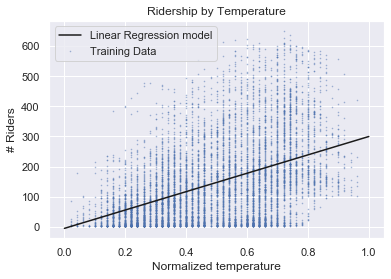

In [24]:
# Your code here
linreg = LinearRegression()
linreg.fit(train_x, train_y)

plt.scatter(train['temp'], train['riders'], s=.3, alpha=.5, label="Training Data")
plt.plot(x, linreg.predict(x), color='k', label="Linear Regression model")
plt.xlabel("Normalized temperature")
plt.ylabel("# Riders")
plt.title("Ridership by Temperature")
plt.legend();


### Question 3.2
Make the plot in Question 3.1 again, still using the same linear model, but implementing the math on your own instead of using `linreg.predict`.

The following expressions extract the parameters that sklearn computed for the linear model.

In [25]:
print("Intercept:", linreg.intercept_)
print("Coefficients:", linreg.coef_)

Intercept: -5.374497364011859
Coefficients: [305.00603825]


Complete this function.

In [26]:
def my_linreg_predict(x, linreg):
    """Return the array of predicted values for each x value, using the supplied linreg model.
    """
    # Your code here
    return linreg.intercept_ + x * linreg.coef_[0]

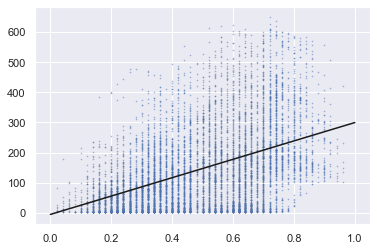

In [27]:
# Plot the graph again. Labeling not necessary this time.
# Your code here.
plt.scatter(train['temp'], train['riders'], s=.3, alpha=.5, label="Training Data")
plt.plot(x, my_linreg_predict(x, linreg), color='k', label="Linear Regression model");


### Question 3.3
What mean squared error does the linear regression model get when predicting on the **training** data?

In [28]:
# Your code here
y_pred = linreg.predict(train_x)
print("Mean squared error of linreg model on training set: {:,.3f} riders^2".format(
    metrics.mean_squared_error(y_true=train_y, y_pred=y_pred)))
print("R^2 of linreg model on training set: {:,.3f}".format(
    metrics.r2_score(y_true=train_y, y_pred=y_pred)))
print("Mean absolute error of linreg model on training set: {:,.3f} riders".format(
    metrics.mean_absolute_error(y_true=train_y, y_pred=y_pred)))

Mean squared error of linreg model on training set: 14,255.203 riders^2
R^2 of linreg model on training set: 0.204
Mean absolute error of linreg model on training set: 91.716 riders


## Question 3.4
What MSE does this same linear regression model get on the **test** data? How does that compare with its training MSE that you computed in 3.3?

In [29]:
# your code here
test_y_pred = linreg.predict(test_x)
print("MSE of linreg on test set: {:,.3f} riders^2".format(
    metrics.mean_squared_error(y_true=test_y, y_pred=test_y_pred)))
print("R^2 of linreg model on test set: {:,.3f} riders".format(
    metrics.r2_score(y_true=test_y, y_pred=test_y_pred)))
print("Mean absolute error of linreg model on test set: {:,.3f} riders".format(
    metrics.mean_absolute_error(y_true=test_y, y_pred=test_y_pred)))

MSE of linreg on test set: 44,780.331 riders^2
R^2 of linreg model on test set: -0.026 riders
Mean absolute error of linreg model on test set: 153.129 riders


*Your answer here*

The test MSE of 44.8k riders^2 is much greater than the training MSE of 14k riders^2.

## Question 3.5
Compare and contrast the 5-NN model and the linear regression model.

* In what ways is the 5-NN model better?
* In what ways is the Linear Regression model better?
* What sort of a pattern does it look like the data actually has? Do you think a linear model is a good fit for it?
* Which one would you use, if you had to pick? Why?

*Your answer here*

* The 5-NN might be following the trend of the data more closely. It could conceivably capture a trend that isn't a straight line.
* The linear regression model does better (lower MSE) on both the training and test set. (In general I'd expect a 5-NN to get much better training accuracy, but the temperature feature of this data only takes on certain discrete values, which is weird...)
* The data varies pretty wildly, but even the general trend doesn't seem to be quite linear. The linear model predicts a negative ride count for some temperature values (including the minimum one in the dataset), which is impossible, and it predicts ridership to continue increasing at the same rate as it gets hotter, which is also implausible.
* If I really had to, I'd use the linear model because it fits a bit better... but the model is still quite bad -- worse than the mean at predicting the test set.

# Question 4
The comparison we made was between a 5-NN and a linear regression model. In this question, we'll think about what if we had chosen a different $k$.

## Question 4.1

Assuming you have named all of your variables as requested, the code below should make a plot very similar to one you made in hw3. We also added a horizontal line for the linear regression's testing MSE.

1. What do you notice about this graph?
2. What value of $k$ should we choose?
3. Would you answer Question 3.5 any differently if using that chosen value of k?

In [30]:
len(np.unique(train_x))

48

In [31]:
train_x += np.random.normal(scale=1e-6, size=train_x.shape)

In [33]:
n_neighbors_vals = list(range(1, 10, 4)) + list(np.linspace(10, len(train), 10).astype(int))
training_mses = []
testing_mses = []
for n_neighbors in n_neighbors_vals:
    print(n_neighbors, end=' ')
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(train_x, train_y)
    training_mses.append(metrics.mean_squared_error(train_y, knn.predict(train_x)))
    testing_mses.append(metrics.mean_squared_error(test_y, knn.predict(test_x)))

1 5 9 10 969 1928 2888 3847 4807 5766 6726 7685 8645 

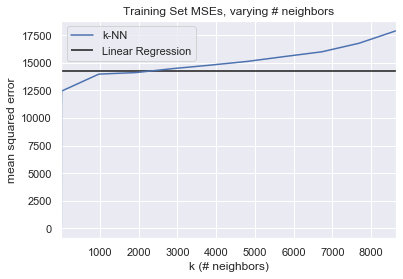

In [34]:
plt.plot(n_neighbors_vals, training_mses, label="k-NN")
plt.hlines(
    metrics.mean_squared_error(y_true=train_y, y_pred=linreg.predict(train_x)),
    n_neighbors_vals[0], n_neighbors_vals[-1], label="Linear Regression")
plt.xlabel("k (# neighbors)")
plt.ylabel("mean squared error");
plt.title("Training Set MSEs, varying # neighbors")
plt.legend()
plt.xlim(n_neighbors_vals[0], n_neighbors_vals[-1]);

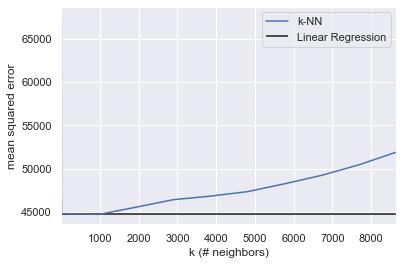

In [35]:
if True: # Run this only once you've answered 4.1
    plt.plot(n_neighbors_vals, testing_mses, label="k-NN")
    plt.hlines(
        metrics.mean_squared_error(y_true=test_y, y_pred=linreg.predict(test_x)),
        n_neighbors_vals[0], n_neighbors_vals[-1], label="Linear Regression")
    plt.xlabel("k (# neighbors)")
    plt.ylabel("mean squared error");
    plt.legend()
    plt.xlim(n_neighbors_vals[0], n_neighbors_vals[-1]);

*Your answer here*